# Bridging the gap between teaching and doing quant finance with QuantSA

Quantitative finance is a broad term, here I am referring to solving pricing problems in the capital markets space (with all their regulatory and other side effects).

I am going to explore the possibility of creating a quant library that:

 * Meets the requirements of a bank to solve pricing problems
 * Has a close link to the fundamental maths concepts so that it can be used for teaching
 
Put differently

 * It is fast and easy to use for actual products
 * You can find $(\Omega, \mathcal{F}, \mathbb{Q})$ and $\mathbb{E}^{\mathbb{Q}}\left[ H(T) \middle| \mathcal{F}_t \right]$ in the code

---

# Overview

 * Summary of teaching and doing objectives
 * Describe the library's main components
 * Show the overlap between describing an economy (teaching) and implementing a product (doing)
 * Implement a product and value it
 * How do models work?
 * Forward Vales and regression as a general tool for higher order cashflow modelling
 * A comment about early exercise
 * Final notes
 * Conclusions
 
 ---
 

# Teaching and Doing

## Teaching

When we teach we are aiming to get students to:

 * Work with SDEs
 * Understand measure changes and risk neutrality
 * See contingent claims as random variables
 * Evaluate expectations of these random variables
 * Learn supporting numerical techniques to evaluate these expectations
 


## Doing

When we do quant work we are aiming to

 * Understand a contract and business's cashflows in all states of the world
 * Select a model that realistically captures the uncertainty of those states of the world
 * Calibrate the model to a cross section of prices
 * Analyse the impacts of different modelling decisions
 * Provide the model user with an easy way to get the fair present value and sensitivities of these cashflows 
 


## Overlap

Unfortunately it seems that these two lists do not have a lot of overlap.

Often we do make some effort to explicitly teach the cashflows for a particular contingent claim, usually for the purpose of deriving some clever closed form price for it.

I am going to propose a setup that links the teaching and doing regions via a pedagogical smooth pasting condition.

Furthermore a key point of the "Doing" section is about delivering working software to the consumers of the models.  Of course not every quant wants to nor needs to be a software developer but the organization where they work must provide a mechanism of getting their models into working software.

This proposal also gets quant students to learn inside a pre-existing software architecture, getting used to this early on and then being able to bring their studying development directly into the work environment.

---

# Main Library Components

 * Market Observables
 * Products (that don't know about models)
 * Models (that don't know about products)
 * a Coordinator and regression layer
 * Higher order cashflows modelling (PV, EPE, CVA, FVA, ...)
 
 ---

# Setting up an Economy

We assume that we have:
 
 * a final time $T$
 * a probability space, a filtration and a measure: $(\Omega, \mathcal{F}, \mathbb{Q})$
 * stochastic processes: $\textbf{W}(t)$  (not necessarily Brownian motions notwithstanding the use of $W$)
 * a numeraire asset $N(t)$ which is a function of $\textbf{W}(t)$, and
 * $K$ market observables are labelled $S_1(t),...S_K(t)$ which are also all functions of $\textbf{W}(t)$
   * these are not necessarily all tradable assets.  They could be things like forward rates or a default indicators

We further assume that the measure $\mathbb{Q}$ is already the risk neutral one so that for any tradable asset $P$ (see later) with cashflows only at $0<t_i<T$ we have

$$ \frac{P(t)}{N(t)} = \mathbb{E}^\mathbb{Q} \left[ \frac{P(t_i)}{N(t_i)} \middle| \mathcal{F}(t) \right] $$



## Tradable Assets/Products

The cashflows on any product or portfolio take place at fixed times and are calculated as functions of the $K$ market observables.  In general if there is a cashflow at $u_i$ it will depend on market observables at times on or before $u_i$

$$ X_i = f(S_{j_0}(v_{k_0}), S_{j_1}(v_{k_1}), ...) $$

with $(j_l, k_l)$ in some set $\mathcal{J}(u_i)$ that depends on the product and $u_i$; and $v_{k_l} \leq u_i$

The value of any product at $t_0$ is then:

$$ V(t_0) =  \mathbb{E}^\mathbb{Q} \left[ \sum_{u_i>t_0}{\frac{S_{xn}(u_i)X_i}{N(u_i)}} \right] $$
<div style="text-align: right"><b> Equation 1</b></div>

Where $N(u_i)$ is the numeraire in the value currency and $S_{xn}$ is that market observable that converts units of the cashflow currency into units of the numeraire currency, i.e. the exchange rate.

Any product without optionality can then be represented by the set of random variables and the times at which the cashflows represented by the random variables take place:

$$ P = \left\{ \left(X_1, u_1\right), ..., \left(X_M, u_M\right) \right\} $$



## Link to Doing

This all seems more like teaching quant finance rather than doing quant finance.

What do the $S$ look like and what does a $P$ look like?

The types of $S$ that exist in QuantSA are:

 * CurrencyPair
 * DefaultRecovery
 * DefaultTime
 * Dividend
 * FloatingIndex
 * Share

And each of these has a specific sub-type.  For example CurrencyPair will have a base and counter currency, DefaultTime will have a company and default type and FloatingIndex will be one of the world's named floating indices such as 3 month Jibar.

The specific sub-type of each of these has a value that taht is a real life market observable: it can be observed on a well defined screen at a well defined time.

The cashflows on a product can be written as functions of these observables.



### Example FRA
The cashflow on a South African FRA depends only on 3m Jibar, let's call that say $S_0$, observed on a single date $u_1$, a fixed rate $K$ and an accrual fraction $\Delta t$:

$$ P_{FRA} = \left\{ \left( (S_0(u_1)-K) \Delta t \frac{1}{1+ S_0(u_1) \Delta t} , u_1 \right) \right\}$$


### Example Equity Call Option
The cashflow on a cash settled equity call option with exercise date $u_1$ on a single share, say $S_1$, with stike $K$:

$$ P_{CALL} = \left\{ \left( \max(S_1(u_1)-K,0), u_1 \right) \right\}$$

---

# Implementing a Product

We have seen the maths of how products are defined, now let us see how to implement them in QuantSA.

## Example code FRA
```cs
Date date = new Date(2017, 08, 28);
FloatingIndex jibar = FloatingIndex.JIBAR3M;
double dt = 91.0/365.0;
double fixedRate = 0.071;
double notional = 1000000.0;
Currency currency = Currency.ZAR;

public override List<Cashflow> GetCFs()
{
    double reset = Get(jibar, date);
    double cfAmount = notional * (reset - fixedRate)*dt/(1+dt*reset);
    return new List<Cashflow>() { new Cashflow(date, cfAmount, currency) };
}
```

## Example code Call

```cs
Date exerciseDate = new Date(2017, 08, 28);
Share share = new Share("AAA", Currency.ZAR);
double strike = 100.0;

public override List<Cashflow> GetCFs()
{
    double amount = Math.Max(0, Get(share, exerciseDate) - strike);
    return new List<Cashflow>() {new Cashflow(exerciseDate, amount, share.currency) };        
}
```

We simply define the market observables and other contract details and implement a formula to describe the cashflow that is defined from these.  The only apparent magic is the function call:

`Get(jibar, date)`

This product description script is common to many quant libraries available on the market and is a little bit like the Portfolio Aggregation Language (PAL) described in Cesari *et al* (2010).  But the vocabulary is smaller, the syntax is straight C#, and there is no information other than what would be contained in the trade confirmation sheet.

As you can see we have "learnt" exactly what a FRA and a call option are in a completely model independent way.

The next step is to look at how to value these products.

---

# Examples of using the Library

## Technicalities

The library is written in C#.  There are many reasons why this makes sense:

 * It is a type-safe, object-oriented language - good for building and maintaining large code bases.
 * It is easier to learn and write than C++
 * It is faster than Python or Matlab
 * It is even becoming portable
 * It plays nicely with the typical bank employee's Microsoft Windows and Office environment
 
Nevertheless Python (or Matlab) remain much more convenient for scientific computing where you are experimenting with different models and methods.

To use QuantSA from Python we need the following:

### Letting Python see the C# Library:

In [1]:
import clr # to be able to use the C# library

clr.AddReference("System.Collections")
clr.AddReference(r'C:\Dev\QuantSA\QuantSA\Valuation\bin\Debug\QuantSA.General.dll')
clr.AddReference(r'C:\Dev\QuantSA\QuantSA\Valuation\bin\Debug\QuantSA.Valuation.dll')

from System.Collections.Generic import List
from QuantSA.General import *
from QuantSA.Valuation import *
print("The library is ready to use!")

The library is ready to use!


## Making a product

In [2]:
source = """Date date = new Date(2017, 8, 28);
FloatingIndex jibar = FloatingIndex.JIBAR3M;
double dt = 91.0/365.0;
double fixedRate = 0.071;
double notional = 1000000.0;
Currency currency = Currency.ZAR;

public override List<Cashflow> GetCFs()
{
    double reset = Get(jibar, date);
    double cfAmount = notional * (reset - fixedRate)*dt/(1+dt*reset);
    return new List<Cashflow>() { new Cashflow(date, cfAmount, currency) };
}
"""
# Make a product at runtime
fra = RuntimeProduct.CreateFromString("MyFRA", source);
print("Now we have a FRA:")
print(fra)


Now we have a FRA:
MyFRA


## Setting up a model

We haven't described how to make a model or exactly what it does but the following code is fairly easy to understand:

In [3]:
# Set up the model
valueDate = Date(2016, 9, 17)
maximumDate = Date(2026, 9, 17)
dates = [Date(2016, 9, 17) , Date(2026, 9, 17)]

rates = [ 0.07, 0.07 ]
discountCurve = DatesAndRates(Currency.ZAR, valueDate, dates, rates, maximumDate)
numeraireModel = DeterminsiticCurves(discountCurve);
otherModels = List[Simulator]() # no model other than discounting for now.
coordinator = Coordinator(numeraireModel, otherModels, 1) # the magic ingredient that gets 
                                                          # models and products to work 
                                                          # together

print("A model is ready.")

A model is ready.


## Valuing the product with the model

In [4]:
# Run the valuation
portfolio = [fra]
value = coordinator.Value(portfolio, valueDate)

IndexOutOfRangeException: Required index: ZAR:JIBAR:3M is not provided by any of the simulators.
   at QuantSA.Valuation.Coordinator.AssociateFactorsWithSimulators(List`1 portfolio) in C:\Dev\QuantSA\QuantSA\Valuation\Coordinator.cs:line 585
   at QuantSA.Valuation.Coordinator.CalculateAll(Product[] portfolioIn, Date valueDate, Date[] fwdValueDates) in C:\Dev\QuantSA\QuantSA\Valuation\Coordinator.cs:line 426
   at QuantSA.Valuation.Coordinator.Value(Product[] portfolioIn, Date valueDate) in C:\Dev\QuantSA\QuantSA\Valuation\Coordinator.cs:line 503

Aha, this is good.  You can't value a FRA with a discounting model because its cashflow depends on 3 month Jibar and your model does not know anything about 3 month Jibar.

With this type of constraint (whihc is deeply embedded in the library):

 * You will never work under the wrong numeraire again
 * You will never use the wrong curve to forecast a rate
 
So we need to fix the model by setting it up to forecast some rates:

In [5]:
# add a forecast curve
forecastCurve = ForecastCurve(valueDate, FloatingIndex.JIBAR3M, dates, rates) # use flat 7% rates for forecasting
numeraireModel.AddRateForecast(forecastCurve) # add the forecast curve to the model

# value the product
portfolio = [fra]
value = coordinator.Value(portfolio, valueDate)

# check the value
import numpy as np
date = Date(2017, 8, 28)
t = (date.value - valueDate.value) / 365.0 # C# operator overloading does not work in Python
dt = 91.0 / 365.0
fixedRate = 0.071
notional = 1000000.0
fwdRate = 0.07
refValue = notional * (fwdRate - fixedRate) * dt / (1 + fwdRate * dt) * np.exp(-t * 0.07);

print("value is: {:.2f}.  Expected {:.2f}".format(value, refValue))

value is: -229.35.  Expected -229.35


And just like that the cashflow definition can be turned into a value.


---

# Implementing a Model

We won't spend much time on implementing models, that remains roughly the same as in the "olden days".  

 * You calibrate to market data, 
 * obtain some parametrization of the stochastic processes $\textbf{W}(t)$ and functions $S_i(t)$, and then
 * simulate the $S$s.
 
The coordinating component moves the simulated values and cashflows between the products and models and does some other magic.

The canonical numerical scheme is Monte Carlo.  For the bulk of real world pricing problems Monte Carlo is the only real option once sufficiently realistic dynamics and enough of the side effects are modelled.

Other numerical schemes can be implemented, for example the FRA model above uses the same machinery but is a curve based valuation which works for many products.  Interestingly even though it uses the general valuation framework and product scripts it is fast.  In a test it valued a large portfolio of swaps averaging 0.5ms per swap.

In principle other schemes would also be possible.

The simulation based valuation boils down to estimating:
$$ V(t_0) =  \mathbb{E}^\mathbb{Q} \left[ \sum_{u_i>t_0}{\frac{S_{xn}(u_i)X_i}{N(u_i)}} \right] $$

as 

$$ V(t_0) \approx \frac{1}{j_{max}+1}  \sum_{j=0}^{j_{max}} \left[ \sum_{u_i>t_0}{\frac{S^{(j)}_{xn}(u_i)X^{(j)}_i}{N^{(j)}(u_i)}} \right] $$

---



# Forward Values

In addition to the cashflows on a product that are explicitly defined by the bilateral contract, there are many other financial effects of trading a product such as:

 1. The need to fund the cashflows
 1. The capital required to be held against the position
 1. The loss in the event the counterparty default
 1. The need to place collateral and fund that collateral position
 1. The gain in the event that we default ourselves !?!?!
 
In general these depend on the bank's fair value of these products at future dates


## Simulating forward values

If we require the forward value at time $t_i > t_0$ we need to evaluate

$$
V(t_i) = N(t_i)\mathbb{E}^\mathbb{Q}\left[ \sum_{u_i>t_i}{\frac{S_{xn}(u_i)X_i}{N(u_i)}} \middle| \mathcal{F}(t_i) \right]
$$

 * Note that $V(t_0)$ is not random since all states of the world agree up to $t_0$ the time we are at when we fit the model and perform the valuation.
 * If $t_i>t_0$ then $V(t_i)$ is random and will be a function of the world observed up to $t_i$
 
This could be evaluated with another Monte Carlo simulation beyond $t_i$ for each state of the world observed up to $t_i$ but this is prohibitively expensive,  so we assume that the $X$s, $S$s and $N$ are Markov and note (see Shreve [4] Def 2.3.6) that 

$$
V(t_i) = g(t_i, \textbf{W}(t_i))
$$

Longstaff and Schwartz [3] describe how to use regression to estimate this function $g$ given realizations of $\sum_{u_i>t_i}{\frac{S_{xn}(u_i)X_i}{N(u_i)}}$

In general $g$ is exactly that function of $\textbf{W}(t_i)$ that minimizes $\mathbb{E}^\mathbb{Q}\left[ \left(g(\textbf{W}(t_i)) - \sum_{u_i>t_i}{\frac{S_{xn}(u_i)X_i}{N(u_i)}} \right)^2 \right]$

Note that we need to apply our own regularity conditions to $g$ in the simulation since otherwise with only a finite number of observations it would be possible to set the square error to zero for one set of paths, this $g$ would then fail for a subsequent set of paths.

In the QuantSA library this problem is solved by the coordinating component and models and products do not need to worry about it.

Lets look at an example of it working:


## Example of obtaining forward values

In [6]:
# Set up a swap, which has a more interesting value profile than a FRA
rate = 0.08
payFixed = True
notional = 1000000
startDate = Date(2016, 9, 17)
tenor = Tenor.Years(5)
swap = IRSwap.CreateZARSwap(rate, payFixed, notional, startDate, tenor)
print("Now we have a swap:")
print(swap)

Now we have a swap:
QuantSA.General.IRSwap


In [7]:
# Set up a stochastic model
valueDate = Date(2016, 9, 17)
a = 0.05
vol = 0.01
flatCurveRate = 0.07
hullWiteSim = HullWhite1F(a, vol, flatCurveRate, flatCurveRate, valueDate)
hullWiteSim.AddForecast(FloatingIndex.JIBAR3M)
hwCoordinator = Coordinator(hullWiteSim, List[Simulator](), 5000)

print("A stochastic rate model is ready (Hull White).")

A stochastic rate model is ready (Hull White).


In [8]:
# make the forward dates on which the values are required
from datetime import datetime
from datetime import timedelta
step = timedelta(days=10)
pyDates = []
date = datetime(2016, 9, 17)
endDate = datetime(2021,9,17)
while date<endDate:
    date += step
    pyDates.append(date)
csDates = [Date(d.year, d.month, d.day) for d in pyDates]

In [9]:
# Get the simulated forward values and the regressors used to obtain them
valuePaths = hwCoordinator.GetValuePaths([swap], valueDate, csDates);
print("Available data:")
for s in valuePaths.GetNames():
    print("   " + s)

Available data:
   fwdCashflowPVs
   regressedFwdsPVs
   regressor0


In [10]:
import sys
sys.path.insert(0, r'C:\Dev\QuantSA\Python')
import quantsa as qsa

fwdCashflowPVs = qsa.getnumpy(valuePaths.Get("fwdCashflowPVs"))
regressor0 = qsa.getnumpy(valuePaths.Get("regressor0"))
regressedFwdsPVs = qsa.getnumpy(valuePaths.Get("regressedFwdsPVs"))



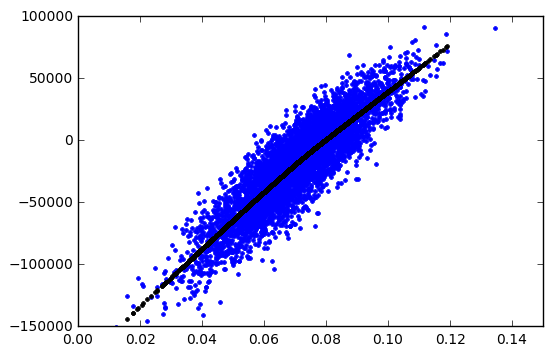

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([0, 0.15])
ax.set_ylim([-150000, 100000])
col = 90 # up to 181
plt.plot(regressor0[:,col], fwdCashflowPVs[:,col],'.')
plt.plot(regressor0[:,col], regressedFwdsPVs[:,col],'k.')

## Expected Positive Exposure



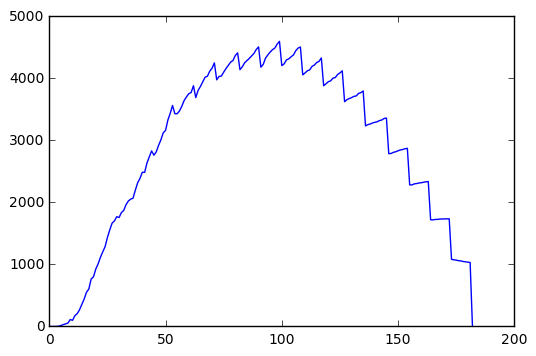

In [12]:
positive_mtm = regressedFwdsPVs
positive_mtm[positive_mtm<0] = 0
epe = np.mean(positive_mtm, 0)
plt.plot(epe)

# Early exercise

For completeness we should at least mention early exercise products.

Stopping times in quant finance are not complicated stochastic control problems.

The only exercise decisions that I have ever seen involve deciding to exercise or not at a set of dates.  Always, when one exercises one knows what the cashflows are as functions of states of the world and similarly if one does not exercise.

The optimal stopping time for the person who owns this right is the one that chooses the alternative with the higher expected value.

This is again a general problem that does not need to be solved for each product and model.

Recall that we defined a product as:

$$ P = \left\{ \left(X_1, u_1\right), ..., \left(X_M, u_M\right) \right\} $$

Similarly we can define a product with early exercise as 

$$
O = P_{noex} \text{ and } \left\{ \left(Q_1, e_1\right), ..., \left(Q_M, e_M\right) \right\}
$$

Where the $Q_i$ are the products that will be exercised into if the optimal stopping time is equal to $e_i$, and the cashflows in $P_{noex}$ will stop at the optimal stopping time.

## Example: Bermudan Swaption

For a Bermudan swaption, there are no flows before exercise.  Once exercise has taken place the cashflows are those from a swap.

We have a swap from above, this forms the $Q_i$ at each of the exercise dates and we simply need to set up the exercise dates:


In [13]:
# Make a Bermudan Swaption
exDates = List[Date]()
exDates.Add(Date(2017, 9, 17))
exDates.Add(Date(2018, 9, 17))
exDates.Add(Date(2019, 9, 17))
exDates.Add(Date(2020, 9, 17))
bermudan = BermudanSwaption(swap, exDates, False)

# Get the simulated forward values and the regressors used to obtain them
valuePaths = hwCoordinator.GetValuePaths([bermudan], valueDate, csDates)
fwdCashflowPVs = qsa.getnumpy(valuePaths.Get("fwdCashflowPVs"))
regressor0 = qsa.getnumpy(valuePaths.Get("regressor0"))
regressedFwdsPVs = qsa.getnumpy(valuePaths.Get("regressedFwdsPVs"))

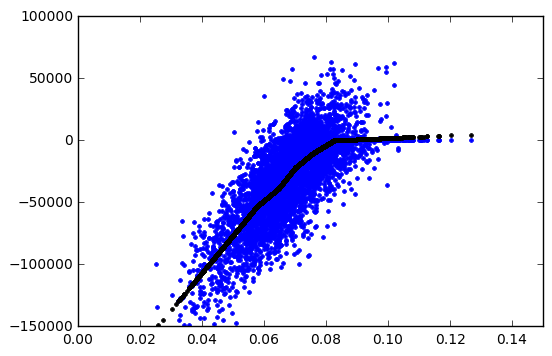

In [14]:
# Examine the values after optimal exercise rule is applied
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([0, 0.15])
ax.set_ylim([-150000, 100000])
col = 70 # up to 181
plt.plot(regressor0[:,col], fwdCashflowPVs[:,col],'.')
plt.plot(regressor0[:,col], regressedFwdsPVs[:,col],'k.')

---
# Final Notes

This library does not change the way all courses would be taught.  I teach an interest rate modelling course where I spend some time actually calibrating and implementing models; and then valuing some products in those models.

Previously this was done in Matlab and only for education purposes.  I believe with this library these same models can still be used for teaching but are also "production ready" and can be used by the students wherever they go after the course.

There are also other topics in the course that I teach that do not have a place directly in the main library framework such as:

 * Measure change 
 * Getting closed form prices in HW and Black
 * How to build trees and 
 * How to derive and solve PDEs
 
These tools and more will be required for calibrating the models in the library... until we come up with a sufficiently fast and general method to use the above framework for calibration too.

---

# Conclusion

With careful software management we can have a library that stays as a bridge between teaching and doing.  The library has a plugin framework that will meet the needs for proprietary models, special cases and user customization without damaging the teaching qualities of the core.

I am hoping that many parts of quant finance can become like optimization: we all learn how to do it but in real life we use standard implementations.

For some reason quant finance still has some "first principles" misconceptions.  I have met people who implement $S_0 exp((r-0.5\sigma^2) \Delta T + \sigma \sqrt{\Delta T} Z)$ into Excel on an almost monthly basis.

## The Future

Finally Python offers us a great way to visualize the future of quant finance with QuantSA:

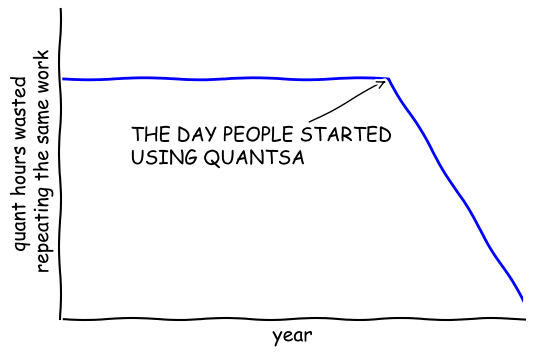

In [15]:
import numpy as np
plt.xkcd()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])
ax.set_ylim([-30, 10])

data = np.ones(100)
data[70:] -= np.arange(30)

plt.annotate(
    'THE DAY PEOPLE STARTED\nUSING QUANTSA',
    xy=(70, 0.9), arrowprops=dict(arrowstyle='->'), xytext=(15, -10))

plt.plot(data)

plt.xlabel('year')
plt.ylabel('quant hours wasted \n repeating the same work')
plt.show()

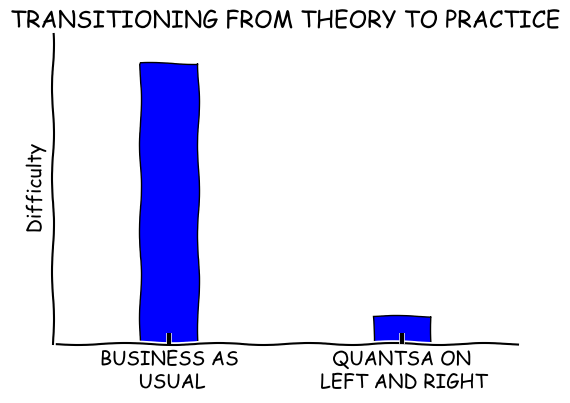

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar([-0.125, 1.0-0.125], [100, 10], 0.25)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([0, 1])
ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 110])
ax.set_xticklabels(['BUSINESS AS\n USUAL', 'QUANTSA ON \n LEFT AND RIGHT'])
plt.yticks([])
plt.ylabel('Difficulty')
plt.title("TRANSITIONING FROM THEORY TO PRACTICE")

plt.show()

# References

[1] Serguei Issakov Alexandre Antonov and Serguei Mechkov. Backward induction for future values.
*Risk*, pages 92-97, 2015.

[2] G. Cesari, J. Aquilina, and N. Charpillon. *Modelling, Pricing, and Hedging Counterparty Credit
Exposure*. Springer, 2010.

[3] Francis A. Longstaff and Eduardo S. Schwartz. Valuing american options by simulation: A
simple least-squares approach. *Review of Financial Studies*, pages 113-147, 2001.

[4] S.E. Shreve. *Stochastic Calculus for Finance II: Continuous-Time Models.* Number v. 11 in
Springer Finance Textbooks. Springer, 2004.

# Resources

<http://www.quantsa.org/>

https://github.com/JamesLTaylor/QuantSA